# Objetivos do trabalho

* Qual time tem os melhores jogadores de defesa, meio-campo e ataque?
* Existe realmente uma vantagem do time da casa?
* As equipes com jogadores mais ofensivos marcam mais gols? E times com goleiros mais fortes recebem menos gols?
* Qual time tem a maior sequência de vitórias?
* O melhor time sempre vence? Você pode explicar por que um time mais fraco às vezes ganha?

In [1]:
from itertools import groupby

from category_encoders.target_encoder import TargetEncoder
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from plotnine import ggplot, geom_bar, facet_wrap, aes, geom_point, coord_flip
from plotnine.coords import coord_cartesian
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import ztest as ztest
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, precision_recall_curve, classification_report
from sklearn.model_selection import cross_val_score, train_test_split

# EDA

In [2]:
data = pd.read_csv("international_matches.csv", parse_dates=["date"])

In [3]:
data.head()

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
0,1993-08-08,Bolivia,Uruguay,South America,South America,59,22,0,0,3,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1993-08-08,Brazil,Mexico,South America,North America,8,14,0,0,1,...,No,Draw,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1993-08-08,Ecuador,Venezuela,South America,South America,35,94,0,0,5,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1993-08-08,Guinea,Sierra Leone,Africa,Africa,65,86,0,0,1,...,No,Win,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1993-08-08,Paraguay,Argentina,South America,South America,67,5,0,0,1,...,No,Lose,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
data.isna().sum()

date                                 0
home_team                            0
away_team                            0
home_team_continent                  0
away_team_continent                  0
home_team_fifa_rank                  0
away_team_fifa_rank                  0
home_team_total_fifa_points          0
away_team_total_fifa_points          0
home_team_score                      0
away_team_score                      0
tournament                           0
city                                 0
country                              0
neutral_location                     0
shoot_out                            0
home_team_result                     0
home_team_goalkeeper_score       15542
away_team_goalkeeper_score       15826
home_team_mean_defense_score     16134
home_team_mean_offense_score     15411
home_team_mean_midfield_score    15759
away_team_mean_defense_score     16357
away_team_mean_offense_score     15609
away_team_mean_midfield_score    15942
dtype: int64

# Identificar a partir de quando temos dados de pontuação das seções dos times

In [5]:
nomes_pontuacoes = [
    "home_team_goalkeeper_score",
    "away_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

columns_has_score = ~data[nomes_pontuacoes].isna()

any_score = columns_has_score.any(axis=1)


In [6]:
elemento_mais_antigo_contem_pontuacao = data[any_score].index.min()
elemento_mais_recente_contem_pontuacao = data[any_score].index.max()

## Partida mais antiga em que foi feita pontuação das seções dos times

In [7]:
data.iloc[[elemento_mais_antigo_contem_pontuacao]]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
8262,2004-09-03,Maldives,Oman,Africa,Asia,142,50,0,0,1,...,No,Lose,NaN,70.0,NaN,NaN,NaN,NaN,NaN,NaN


## Partida mais recente em que foi feita pontuação das seções dos times

In [8]:
data.iloc[[elemento_mais_recente_contem_pontuacao]]

,date,home_team,away_team,home_team_continent,away_team_continent,home_team_fifa_rank,away_team_fifa_rank,home_team_total_fifa_points,away_team_total_fifa_points,home_team_score,...,shoot_out,home_team_result,home_team_goalkeeper_score,away_team_goalkeeper_score,home_team_mean_defense_score,home_team_mean_offense_score,home_team_mean_midfield_score,away_team_mean_defense_score,away_team_mean_offense_score,away_team_mean_midfield_score
23920,2022-06-14,Korea Republic,Egypt,Asia,Africa,29,32,1519,1500,4,...,No,Win,75.0,NaN,73.0,80.0,73.8,NaN,79.3,70.8


# Qual time tem os melhores jogadores de defesa, meio-campo e ataque?

In [9]:
colunas_time_casa = [
    "date",
    "home_team",
    "home_team_fifa_rank",
    "home_team_total_fifa_points",
    "home_team_score",
    "home_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
]

colunas_time_visitante = [
    "date",
    "away_team",
    "away_team_fifa_rank",
    "away_team_total_fifa_points",
    "away_team_score",
    "away_team_goalkeeper_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

partidas_com_pontuacao = data.iloc[
    elemento_mais_antigo_contem_pontuacao:elemento_mais_recente_contem_pontuacao
]

dados_time_casa = partidas_com_pontuacao[colunas_time_casa]
dados_time_visitante = partidas_com_pontuacao[colunas_time_visitante]

dados_time_casa_renomeado = dados_time_casa.rename(
    mapper=lambda x: x.replace("home_team_", ""), axis=1
)
dados_time_casa_renomeado = dados_time_casa_renomeado.rename(
    mapper=lambda x: x.replace("home_team", "team"), axis=1
)

dados_time_visitante_renomeado = dados_time_visitante.rename(
    mapper=lambda x: x.replace("away_team_", ""), axis=1
)
dados_time_visitante_renomeado = dados_time_visitante_renomeado.rename(
    mapper=lambda x: x.replace("away_team", "team"), axis=1
)


pontuacao_paises = pd.concat(
    [dados_time_casa_renomeado, dados_time_visitante_renomeado], axis=0
)


In [10]:
pontuacao_paises["ano"] = pontuacao_paises["date"].dt.year

## Pontuação dos times muda durante o ano?

In [11]:
nomes_pontuacoes = [
    "mean_defense_score",
    "mean_offense_score",
    "mean_midfield_score",
    "goalkeeper_score",
]

var_pontuacao = pontuacao_paises.groupby(["ano", "team"])[
    nomes_pontuacoes
].var()


In [12]:
pontuacoes_variam_no_ano = var_pontuacao.apply(lambda x: x>0)

print(pontuacoes_variam_no_ano.any())

mean_defense_score     True
mean_offense_score     True
mean_midfield_score    True
goalkeeper_score       True
dtype: bool


In [13]:
var_pontuacao[pontuacoes_variam_no_ano.values]

mean_defense_score  mean_offense_score  mean_midfield_score  \
ano  team                                                                    
2005 Albania                  NaN            4.314333             0.058333   
     Albania                  NaN            4.314333             0.058333   
     Algeria               0.0000            0.402381             0.952381   
     Algeria               0.0000            0.402381             0.952381   
     Angola                0.0000            0.818182                  NaN   
...                           ...                 ...                  ...   
2021 Wales                 0.0105            2.362500             0.443625   
     Wales                 0.0105            2.362500             0.443625   
     Wales                 0.0105            2.362500             0.443625   
     Zambia                   NaN            0.504000                  NaN   
     Zimbabwe              0.0000            5.770909             0.000000   

               goalkeeper_score  
ano  team                        
2005 Albania                NaN  
     Albania                NaN  
     Algeria             0.0000  
     Algeria             0.0000  
     Angola              0.0000  
...                         ...  
2021 Wales               0.2625  
     Wales               0.2625  
     Wales               0.2625  
     Zambia                 NaN  
     Zimbabwe               NaN  

[4347 rows x 4 columns]

## Média das pontuações por sessão

In [14]:
media_defesa_pais_ano = pontuacao_paises.groupby(["ano", "team"])[
    "mean_defense_score"
].mean()
media_defesa_pais_ano.sort_values(ascending=False)


ano   team      
2004  Italy         91.800000
2005  Italy         91.000000
2004  England       90.500000
2005  England       90.045455
2006  Italy         89.450000
                      ...    
2022  Uzbekistan          NaN
      Vanuatu             NaN
      Vietnam             NaN
      Yemen               NaN
      Zambia              NaN
Name: mean_defense_score, Length: 3550, dtype: float64

In [15]:
media_defesa_pais_ano = pontuacao_paises.groupby(["ano", "team"])[
    "mean_offense_score"
].mean()
media_defesa_pais_ano.sort_values(ascending=False)


ano   team             
2004  Netherlands          93.0
      France               93.0
2005  Brazil               92.4
2004  Italy                92.3
      Brazil               92.3
                           ... 
2022  US Virgin Islands     NaN
      Uzbekistan            NaN
      Vanuatu               NaN
      Vietnam               NaN
      Yemen                 NaN
Name: mean_offense_score, Length: 3550, dtype: float64

In [16]:
media_defesa_pais_ano = pontuacao_paises.groupby(["ano", "team"])[
    "mean_midfield_score"
].mean()
media_defesa_pais_ano.sort_values(ascending=False)


ano   team    
2004  France      93.200000
      England     91.200000
2005  France      90.909091
2006  Brazil      90.500000
2005  Brazil      90.350000
                    ...    
2022  Vanuatu           NaN
      Vietnam           NaN
      Yemen             NaN
      Zambia            NaN
      Zimbabwe          NaN
Name: mean_midfield_score, Length: 3550, dtype: float64

In [17]:
media_defesa_pais_ano = pontuacao_paises.groupby(["ano", "team"])[
    "goalkeeper_score"
].mean()
media_defesa_pais_ano.sort_values(ascending=False)


ano   team      
2004  Italy         97.000
2005  Italy         96.000
      Spain         94.500
2006  Italy         94.375
2004  Spain         94.000
                     ...  
2022  Uzbekistan       NaN
      Vanuatu          NaN
      Yemen            NaN
      Zambia           NaN
      Zimbabwe         NaN
Name: goalkeeper_score, Length: 3550, dtype: float64

# Existe realmente uma vantagem do time da casa?

In [18]:
resultado = data[
    [
        "date",
        "home_team",
        "home_team_result",
        "neutral_location",
        "city",
        "country",
    ]
]


In [19]:
resultado["time_casa_em_casa"] = (
    resultado["home_team"].values == resultado["country"].values
)

/tmp/ipykernel_5257/2506403630.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [20]:
resultado

,date,home_team,home_team_result,neutral_location,city,country,time_casa_em_casa
0,1993-08-08,Bolivia,Win,False,La Paz,Bolivia,True
1,1993-08-08,Brazil,Draw,False,Maceió,Brazil,True
2,1993-08-08,Ecuador,Win,False,Quito,Ecuador,True
3,1993-08-08,Guinea,Win,False,Conakry,Guinea,True
4,1993-08-08,Paraguay,Lose,False,Asunción,Paraguay,True
...,...,...,...,...,...,...,...
23916,2022-06-14,Moldova,Win,False,Chișinău,Moldova,True
23917,2022-06-14,Liechtenstein,Lose,False,Vaduz,Liechtenstein,True
23918,2022-06-14,Chile,Lose,True,Suita,Japan,False
23919,2022-06-14,Japan,Lose,False,Suita,Japan,True


In [21]:
resultado_por_locacao = resultado.groupby(["time_casa_em_casa"])[
    "home_team_result"
].value_counts()


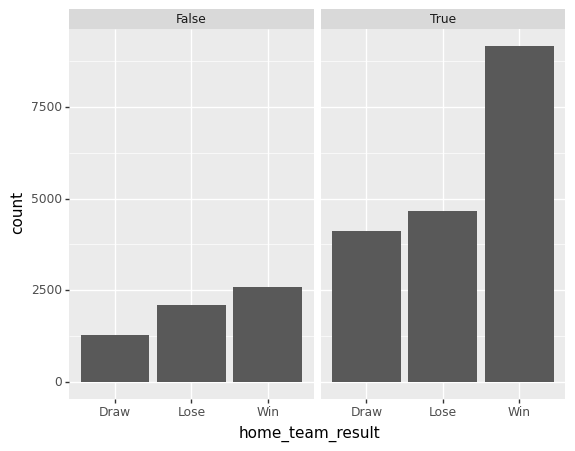

<ggplot: (8750223084042)>

In [22]:
(ggplot(resultado, aes("home_team_result"))
+ geom_bar()
+ facet_wrap("time_casa_em_casa")
)

In [23]:
resultado_por_locacao_renomeado = resultado_por_locacao.to_frame().rename(
    columns={"home_team_result": "results_count"}
)

contagem_resultados = resultado_por_locacao_renomeado.reset_index()

In [24]:
tabela_contigencia = contagem_resultados.pivot(
    index="home_team_result",
    columns="time_casa_em_casa",
    values="results_count",
)

In [25]:
_, p_valor, *_ = chi2_contingency(tabela_contigencia, correction=True)

nivel_signficancia = 0.05

if p_valor < nivel_signficancia:
    print(f"p valor de {p_valor:.3f}, amostras são diferentes")
else:
    print(
        f"p valor de {p_valor}, amostras não podem ser consideradas diferentes"
    )


p valor de 0.000, amostras são diferentes


# As equipes com jogadores mais ofensivos marcam mais gols? E times com goleiros mais fortes recebem menos gols?

In [26]:
dados_a_partir_pontuacao = data.iloc[elemento_mais_antigo_contem_pontuacao:]

saldo_gols = dados_a_partir_pontuacao.copy()

saldo_gols["saldo_gols"] = saldo_gols["home_team_score"] - saldo_gols["away_team_score"]

In [27]:
saldo_gols_time_casa = saldo_gols[
    [
        "date",
        "home_team",
        "home_team_score",
        "away_team_score",
        "home_team_goalkeeper_score",
        "home_team_mean_offense_score",
        "saldo_gols"
    ]
]

saldo_gols_time_visitante = saldo_gols[
    [
        "date",
        "away_team",
        "home_team_score",
        "away_team_score",
        "away_team_goalkeeper_score",
        "away_team_mean_offense_score",
        "saldo_gols"
    ]
]

saldo_gols_time_visitante["saldo_gols"] = -1 * saldo_gols_time_visitante["saldo_gols"]

/tmp/ipykernel_5257/2326486360.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [28]:
saldo_gols_time_casa_renomeado = saldo_gols_time_casa.rename(
    columns={
        "home_team": "time",
        "home_team_score": "gols_feitos",
        "away_team_score": "gols_levados",
        "home_team_goalkeeper_score": "pontuacao_goleiro",
        "home_team_mean_offense_score": "pontuacao_ataque",
    }
)

saldo_gols_time_visitante_renomeado = saldo_gols_time_visitante.rename(
    columns={
        "away_team": "time",
        "home_team_score": "gols_levados",
        "away_team_score": "gols_feitos",
        "away_team_goalkeeper_score": "pontuacao_goleiro",
        "away_team_mean_offense_score": "pontuacao_ataque",
    }
)


In [29]:
saldo_total = pd.concat(
    [saldo_gols_time_casa_renomeado, saldo_gols_time_visitante_renomeado]
)

saldo_total_todas_pontuacoes = saldo_total.dropna()


In [30]:
media_indicadores = saldo_total_todas_pontuacoes.groupby("time")[
    ["gols_feitos", "gols_levados", "pontuacao_goleiro", "pontuacao_ataque", "saldo_gols"]
].mean()


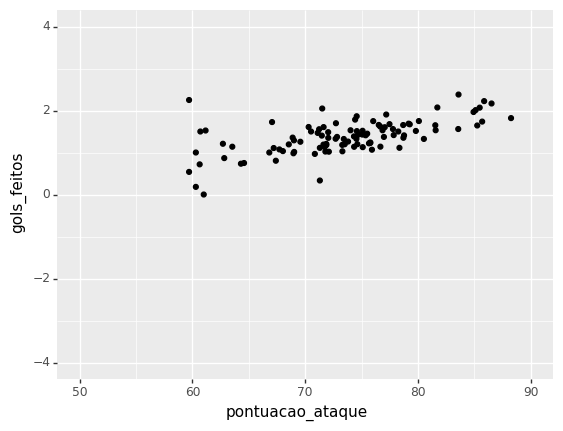

<ggplot: (8750220837048)>

In [31]:
p = ggplot(aes(x='pontuacao_ataque', y='gols_feitos'), media_indicadores)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

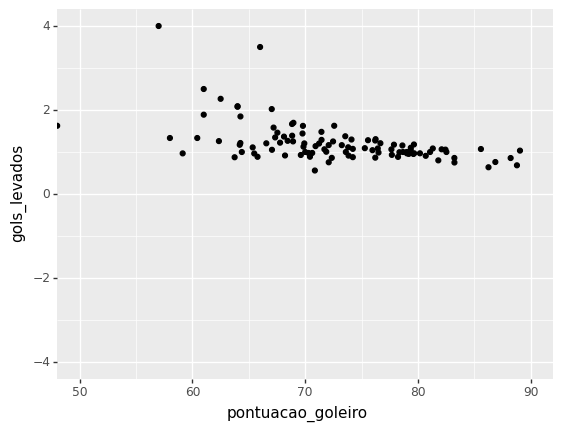

<ggplot: (8750220785475)>

In [32]:
p = ggplot(aes(x='pontuacao_goleiro', y='gols_levados'), media_indicadores)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

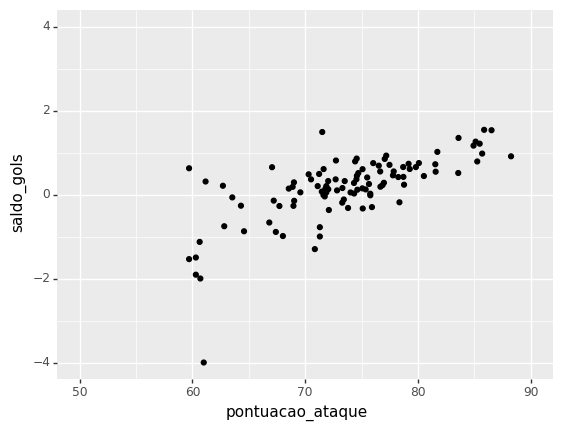

<ggplot: (8750220729450)>

In [33]:
p = ggplot(aes(x='pontuacao_ataque', y='saldo_gols'), media_indicadores)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

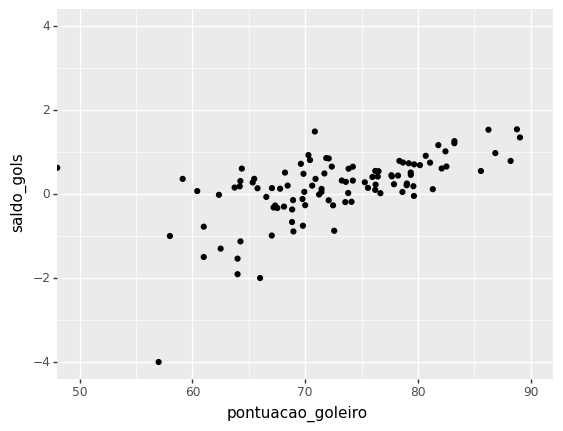

<ggplot: (8750220705994)>

In [34]:
p = ggplot(aes(x='pontuacao_goleiro', y='saldo_gols'), media_indicadores)
p + geom_point() + coord_cartesian(xlim=(50,90), ylim=(-4, 4))

In [35]:
times_por_gols_feitos = media_indicadores.sort_values(
    by="gols_feitos", ascending=False
)
times_por_gols_levados = media_indicadores.sort_values(
    by="gols_levados", ascending=False
)

In [36]:
times_por_gols_feitos

,gols_feitos,gols_levados,pontuacao_goleiro,pontuacao_ataque,saldo_gols
time,,,,,
Germany,2.380165,1.033058,89.053719,83.602066,1.347107
Barbados,2.250000,1.625000,48.000000,59.700000,0.625000
Spain,2.223629,0.683544,88.784810,85.874684,1.540084
Brazil,2.167347,0.636735,86.261224,86.531020,1.530612
Belgium,2.072165,1.056701,82.443299,81.723196,1.015464
...,...,...,...,...,...
Moldova,0.717949,1.846154,64.256410,60.638462,-1.128205
Cyprus,0.538462,2.076923,64.000000,59.700000,-1.538462
Guinea-Bissau,0.333333,1.333333,58.000000,71.300000,-1.000000


In [37]:
times_por_gols_levados

,gols_feitos,gols_levados,pontuacao_goleiro,pontuacao_ataque,saldo_gols
time,,,,,
Central African Republic,0.000000,4.000000,57.000000,61.000000,-4.000000
Haiti,1.500000,3.500000,66.000000,60.700000,-2.000000
Bermuda,1.000000,2.500000,61.000000,60.300000,-1.500000
Armenia,0.966667,2.266667,62.500000,70.856667,-1.300000
Malta,0.181818,2.090909,64.000000,60.300000,-1.909091
...,...,...,...,...,...
Morocco,1.602041,0.755102,72.086735,77.056122,0.846939
England,2.009259,0.750000,83.240741,85.118981,1.259259
Spain,2.223629,0.683544,88.784810,85.874684,1.540084


### Analisando barbados

In [38]:
partidas_barbados = (data["home_team"] == "Barbados") | (data["away_team"] == "Barbados")

informacoes_barbados = data.loc[partidas_barbados]

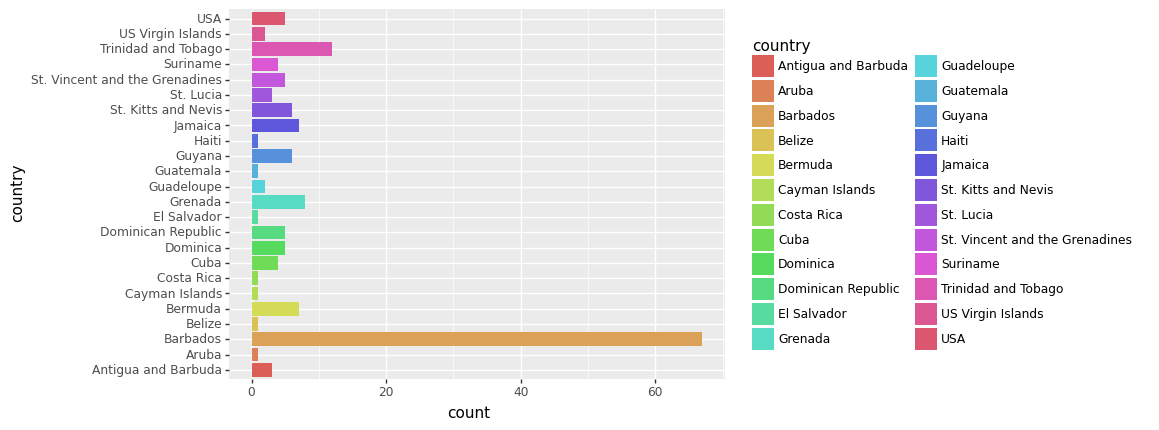

<ggplot: (8750220705940)>

In [39]:
p = ggplot(informacoes_barbados, aes('country', fill='country'))
p  + geom_bar() + coord_flip()

## Ataque dos times que mais fizeram gols é diferente do que menos fizeram? E pontuação do goleiro para o que mais levaram gols?

In [40]:
n_mais_relavantes = 20


mais_fizeram_gols = times_por_gols_feitos.iloc[:n_mais_relavantes]
mais_levaram_gols = times_por_gols_levados.iloc[:n_mais_relavantes]

pontuacao_ataque_mais_fizeram_gols = mais_fizeram_gols["pontuacao_ataque"].values
pontuacao_ataque_mais_levaram_gols = mais_levaram_gols["pontuacao_ataque"].values

pontuacao_goleiro_mais_fizeram_gols = mais_fizeram_gols["pontuacao_goleiro"].values
pontuacao_goleiro_mais_levaram_gols = mais_levaram_gols["pontuacao_goleiro"].values

In [41]:
_, p_valor = ztest(pontuacao_ataque_mais_fizeram_gols, pontuacao_ataque_mais_levaram_gols, value=0)

nivel_significancia = 0.05

if p_valor < nivel_signficancia:
    print(f"p valor de {p_valor:.3f}, ataques são diferentes")
else:
    print(
        f"p valor de {p_valor}, ataques não podem ser consideradas diferentes"
    )


p valor de 0.000, ataques são diferentes


In [42]:
_, p_valor = ztest(
    pontuacao_goleiro_mais_fizeram_gols, pontuacao_goleiro_mais_levaram_gols, value=0
)

if p_valor < nivel_signficancia:
    print(f"p valor de {p_valor:.3f}, goleiros são diferentes")
else:
    print(
        f"p valor de {p_valor}, goleiros não podem ser consideradas diferentes"
    )

p valor de 0.000, goleiros são diferentes


# Qual time tem a maior sequência de vitórias?

In [43]:
partidas_casa = data[["date", "home_team", "tournament", "city", "country", "home_team_result"]]

partidas_visitante = data[["date", "away_team", "tournament", "city", "country", "home_team_result"]]

In [44]:
partidas_casa_sem_empate = partidas_casa.copy()
partidas_casa_sem_empate.loc[partidas_casa_sem_empate["home_team_result"] == "Draw", "home_team_result"] = np.nan

partidas_casa_sem_empate = partidas_casa_sem_empate.dropna()


partidas_visitante_sem_empate = partidas_visitante.copy()
partidas_visitante_sem_empate.loc[partidas_visitante_sem_empate["home_team_result"] == "Draw", "home_team_result"] = np.nan

partidas_visitante_sem_empate = partidas_visitante_sem_empate.dropna()

In [45]:
partidas_casa_sem_empate["ganhou"] = partidas_casa_sem_empate["home_team_result"] == "Win"

partidas_visitante_sem_empate["ganhou"] = partidas_visitante_sem_empate["home_team_result"] == "Lose"

In [46]:
partidas_casa_sem_empate = partidas_casa_sem_empate.rename(columns={"home_team": "team"})
partidas_casa_sem_empate = partidas_casa_sem_empate.drop(columns=["home_team_result"])

partidas_visitante_sem_empate = partidas_visitante_sem_empate.rename(columns={"away_team": "team"})
partidas_visitante_sem_empate = partidas_visitante_sem_empate.drop(columns=["home_team_result"])

In [47]:
resultado_partidas = pd.concat([partidas_casa_sem_empate, partidas_visitante_sem_empate], axis=0)

resultado_partidas_ordenado = resultado_partidas.sort_values(by=["team", "date"]).reset_index(drop=True)

In [48]:
times = resultado_partidas_ordenado["team"].unique()

maior_sequencia_vitorias = 0
time_maior_sequencia_vitorias = None

for time in times:

    resultados_time = resultado_partidas_ordenado[resultado_partidas_ordenado["team"] == time]

    vitorias_time = resultados_time["ganhou"].values

    sequencia_vitorias = [list(group) for item, group in groupby(vitorias_time) if item == True]

    maior_sequencia_vitorias_time = len(max(sequencia_vitorias, key=len))

    if maior_sequencia_vitorias_time > maior_sequencia_vitorias:
        maior_sequencia_vitorias = maior_sequencia_vitorias_time
        time_maior_sequencia_vitorias = time


In [49]:
print(f"time com maior sequencia de vitorias foi {time_maior_sequencia_vitorias}, com {maior_sequencia_vitorias} vitorias")

time com maior sequencia de vitorias foi Spain, com 33 vitorias


# Classificador para predizer derrota

## Desconsiderando empates

In [50]:
dados_comeco_avaliacam_scores = data.iloc[elemento_mais_antigo_contem_pontuacao:]

dados_sem_empate = dados_comeco_avaliacam_scores[dados_comeco_avaliacam_scores["home_team_result"] != "Draw"]


partidas_time_da_casa_joga_em_casa = dados_sem_empate["country"] == dados_sem_empate["home_team"]
partidas_time_visitante_joga_em_casa = dados_sem_empate["country"] == dados_sem_empate["away_team"]

partidas_neutras = dados_sem_empate["neutral_location"]

In [51]:
sem_empate_status_de_onde_esta_jogando = dados_sem_empate.copy()

sem_empate_status_de_onde_esta_jogando.loc[partidas_time_da_casa_joga_em_casa, "local_partida"] = "Casa"
sem_empate_status_de_onde_esta_jogando.loc[partidas_time_visitante_joga_em_casa, "local_partida"] = "Visitante"
sem_empate_status_de_onde_esta_jogando.loc[partidas_neutras, "local_partida"] = "Neutro"

In [52]:
# Não tem partidas no visitante?

sem_empate_status_de_onde_esta_jogando["local_partida"].value_counts()

Casa      8956
Neutro    3150
Name: local_partida, dtype: int64

In [53]:
dev_data = sem_empate_status_de_onde_esta_jogando.query("date < '01-01-2022'")
test_data = sem_empate_status_de_onde_esta_jogando.query("date >= '01-01-2022'")

In [54]:
assert dev_data.date.max() <= pd.to_datetime("12-31-2021")
assert test_data.date.min() >= pd.to_datetime("01-01-2022")

In [55]:
dev_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11662 entries, 8262 to 23349
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           11662 non-null  datetime64[ns]
 1   home_team                      11662 non-null  object        
 2   away_team                      11662 non-null  object        
 3   home_team_continent            11662 non-null  object        
 4   away_team_continent            11662 non-null  object        
 5   home_team_fifa_rank            11662 non-null  int64         
 6   away_team_fifa_rank            11662 non-null  int64         
 7   home_team_total_fifa_points    11662 non-null  int64         
 8   away_team_total_fifa_points    11662 non-null  int64         
 9   home_team_score                11662 non-null  int64         
 10  away_team_score                11662 non-null  int64         
 11  tournament  

In [56]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 450 entries, 23350 to 23920
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           450 non-null    datetime64[ns]
 1   home_team                      450 non-null    object        
 2   away_team                      450 non-null    object        
 3   home_team_continent            450 non-null    object        
 4   away_team_continent            450 non-null    object        
 5   home_team_fifa_rank            450 non-null    int64         
 6   away_team_fifa_rank            450 non-null    int64         
 7   home_team_total_fifa_points    450 non-null    int64         
 8   away_team_total_fifa_points    450 non-null    int64         
 9   home_team_score                450 non-null    int64         
 10  away_team_score                450 non-null    int64         
 11  tournament   

In [57]:
nomes_features = [
    "local_partida",
    "home_team_goalkeeper_score",
    "home_team_mean_defense_score",
    "home_team_mean_offense_score",
    "home_team_mean_midfield_score",
    "away_team_goalkeeper_score",
    "away_team_mean_defense_score",
    "away_team_mean_offense_score",
    "away_team_mean_midfield_score",
]

nome_alvo = "home_team_result"

## Treinar modelo de regressão logística

### Separar conjunto de desenvolvimento em treino e teste

In [58]:
features = dev_data[nomes_features]
features_sem_faltantes = features.fillna(0)

alvo_encoded = dev_data[nome_alvo].map(lambda x: 0 if x == "Win" else 1)

encoder = TargetEncoder()

features_train, features_val, y_train, y_val = train_test_split(features_sem_faltantes, alvo_encoded, test_size=0.2)

features_train = encoder.fit_transform(features_train, y_train)

features_val = encoder.transform(features_val)

/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-WfP819LB/lib/python3.9/site-packages/category_encoders/target_encoder.py:122: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
/home/felipe/.local/share/virtualenvs/fifa_matches_analysis-WfP819LB/lib/python3.9/site-packages/category_encoders/target_encoder.py:127: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327


In [59]:
X_train = features_train.values

X_val = features_val.values

In [60]:
logreg = LogisticRegression()

cross_val_score(logreg, X_train, y_train, cv=3, n_jobs=-1)

array([0.70707395, 0.70128617, 0.71212609])

In [61]:
logreg.fit(X_train, y_train)

LogisticRegression()

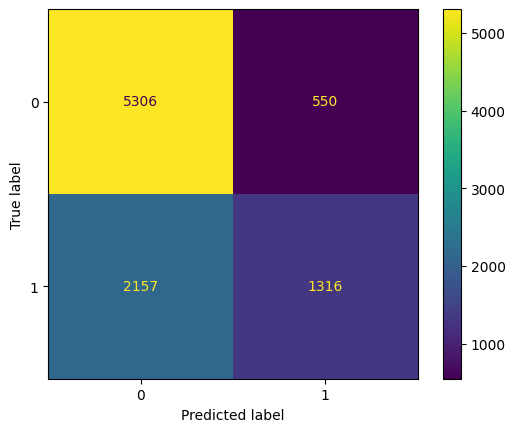

In [62]:
y_pred_train = logreg.predict(X_train)

cm_train = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()
plt.show()

### Desempenho para conjunto de validação

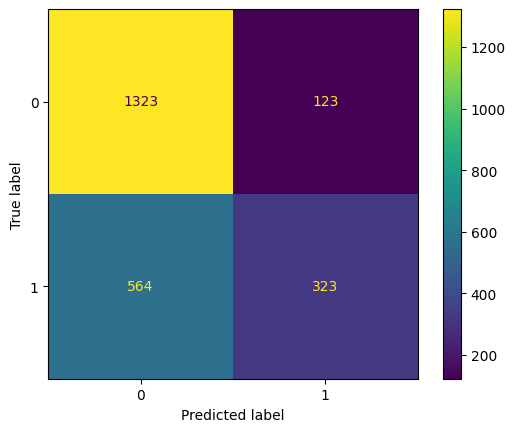

In [63]:
y_pred_val = logreg.predict(X_val)

cm_val = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)

disp.plot()
plt.show()

In [64]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.70      0.91      0.79      1446
           1       0.72      0.36      0.48       887

    accuracy                           0.71      2333
   macro avg       0.71      0.64      0.64      2333
weighted avg       0.71      0.71      0.68      2333



### Curva de precisão e sensibilidade

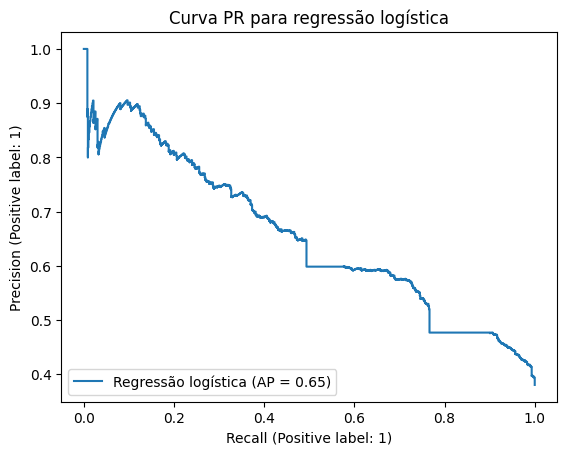

In [65]:
display = PrecisionRecallDisplay.from_estimator(logreg, X_val, y_val, name="Regressão logística")

display.ax_.set_title("Curva PR para regressão logística")

plt.show()

In [66]:
def gerar_curva_pr_com_limites(precisions, recalls,thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precisão")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("limites")
    plt.legend()

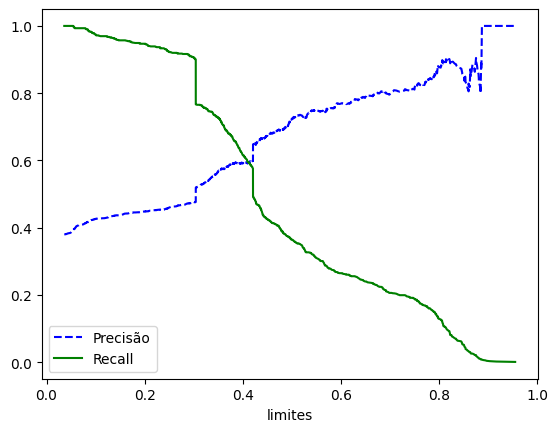

In [67]:
y_val_pred_proba = logreg.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

gerar_curva_pr_com_limites(precisions, recalls,thresholds)
plt.show()

## Treinar modelo de Random Forest

In [68]:
random_forest = RandomForestClassifier()

random_forest.fit(X_train, y_train)

RandomForestClassifier()

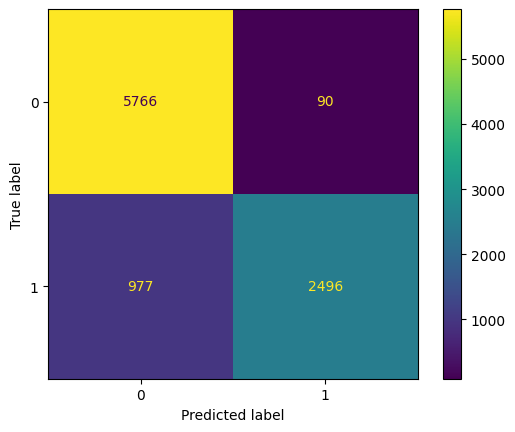

In [69]:
y_pred_train = random_forest.predict(X_train)

cm_train = confusion_matrix(y_train, y_pred_train)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_train)

disp.plot()
plt.show()

### Aplicar no conjunto de validação

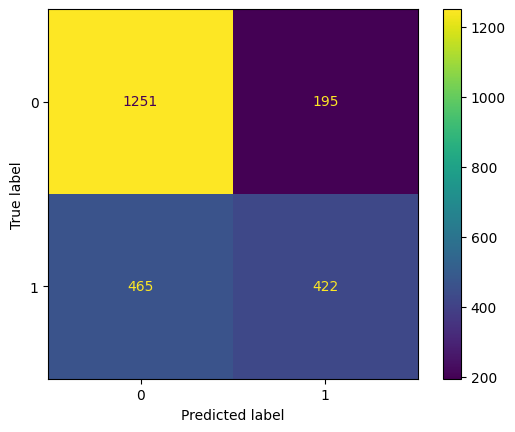

In [70]:
y_pred_val = random_forest.predict(X_val)

cm_val = confusion_matrix(y_val, y_pred_val)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_val)

disp.plot()
plt.show()

In [71]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.73      0.87      0.79      1446
           1       0.68      0.48      0.56       887

    accuracy                           0.72      2333
   macro avg       0.71      0.67      0.68      2333
weighted avg       0.71      0.72      0.70      2333



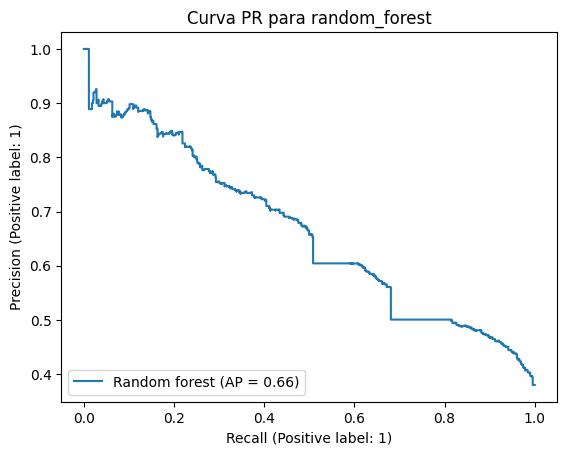

In [72]:
display = PrecisionRecallDisplay.from_estimator(random_forest, X_val, y_val, name="Random forest")

display.ax_.set_title("Curva PR para random_forest")

plt.show()

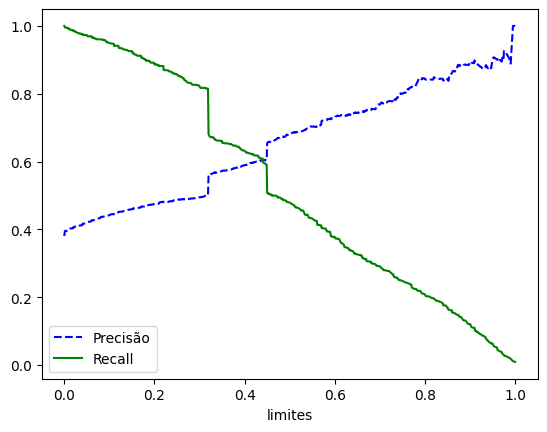

In [73]:
y_val_pred_proba = random_forest.predict_proba(X_val)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_pred_proba)

gerar_curva_pr_com_limites(precisions, recalls,thresholds)
plt.show()

## Aplicar no conjunto de teste

In [74]:
features_test = test_data[nomes_features]
features_test_sem_faltantes = features_test.fillna(0)

alvo_encoded_test = test_data[nome_alvo].map(lambda x: 0 if x == "Win" else 1)

In [75]:
features_test_encoded = encoder.transform(features_test_sem_faltantes)

In [76]:
X_test = features_test_encoded.values

y_test = alvo_encoded_test.values

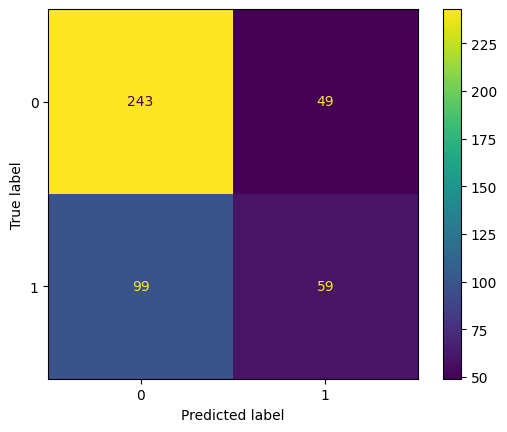

In [77]:
y_pred_test = random_forest.predict(X_test)

cm_dev = confusion_matrix(y_test, y_pred_test)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_dev)

disp.plot()

plt.show()

In [78]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.83      0.77       292
           1       0.55      0.37      0.44       158

    accuracy                           0.67       450
   macro avg       0.63      0.60      0.61       450
weighted avg       0.65      0.67      0.65       450

